In [ ]:
"""Implementations of algorithms for continuous control."""
import functools
from jaxrl_m.typing import *

import jax
import jax.lax as lax
import jax.numpy as jnp
import numpy as np
import optax
from jaxrl_m.common import TrainState, target_update, nonpytree_field
from jaxrl_m.networks import Policy, Critic, ensemblize

import flax
import flax.linen as nn
from functools import partial

NUM_ROLLOUTS = 10
NUM_CRITICS = 5

class Temperature(nn.Module):
    initial_temperature: float = 1e-3
    

    @nn.compact
    def __call__(self) -> jnp.ndarray:
        log_temp = self.param('log_temp',
                              init_fn=lambda key: jnp.full(
                                  (), self.initial_temperature))
        
        return jnp.abs(log_temp)

class SACAgent(flax.struct.PyTreeNode):
    rng: PRNGKey
    critic: TrainState
    temp_critic: TrainState
    actor: TrainState
    temp: TrainState
    config: dict = nonpytree_field()
    
    #def update_temp_critic(agent,transitions,idxs,num_steps):
    @partial(jax.jit,static_argnames=('num_steps',))  
    def update_many_critics(agent,transitions: Batch,idxs:jnp.array,num_steps:int,R2):

        def update_one_critic(critic,idxs,
                            agent,transitions,num_steps):
            
            def one_update(agent,critic,batch: Batch):
                                  
                def critic_loss_fn(critic_params):
                            
                            
                            
                            next_dist = agent.actor(batch['next_observations'])
                            next_actions, next_log_probs = next_dist.sample_and_log_prob(seed=agent.rng)

                            concat_actions = jnp.concatenate([batch["actions"],next_actions])
                            concat_observations = jnp.concatenate([batch["observations"],batch["next_observations"]])
                            
                            concat_q = agent.critic(concat_observations, concat_actions,
                                                    True,params=critic_params)
                            q,next_q = jnp.split(concat_q,2,axis=0) ## axis=1 for ensemble
                            target_q = batch['rewards'] + agent.config['discount'] * batch['masks'] * next_q
                            
                            
                            target_q = jax.lax.stop_gradient(target_q)
                            critic_loss = ((target_q-q)**2).mean()
                            
                            return critic_loss, {
                            'critic_loss': critic_loss,
                            'q1': q.mean(),
                        }  
                    
        
                new_critic, critic_info = critic.apply_loss_fn(loss_fn=critic_loss_fn, has_aux=True)
                new_rng, curr_key, next_key = jax.random.split(agent.rng, 3)
                return agent.replace(rng=new_rng),new_critic
            
            
            get_batch = lambda transitions,idx : jax.tree_map(lambda x : x[idx],transitions)
                
            agent,new_critic = jax.lax.fori_loop(0, num_steps, 
                        lambda i, args: one_update(*args,get_batch(transitions,idxs[i])),
                        (agent,critic))
            
            return new_critic
        
        
        critic = agent.critic
        
        ###### Reset critic params ######
        
        reset = lambda rng,params : critic.init(rng,
                                                agent.config["observations"], agent.config["actions"],False)["params"]
        no_reset = lambda rng,params: params
        f = lambda  mask,rng,params :lax.cond(mask,reset,no_reset,rng,params)
        mask = jnp.zeros((NUM_CRITICS))
        mask.at[jnp.argmin(R2)].set(1)
        rngs = jax.random.split(agent.rng, NUM_CRITICS)
        critic_params = jax.vmap(f,in_axes=(0,0,0))(mask,rngs,critic.params)
        ###################################
        critic_def = Critic((256,256))
        critics = jax.vmap(TrainState.create,in_axes=(None,0,None))(critic_def,critic_params,optax.adam(learning_rate=3e-4))
        tmp = partial(update_one_critic,agent=agent,transitions=transitions,num_steps=num_steps)
        new_critics = jax.vmap(tmp,in_axes=(0,0))(critics,idxs)
        agent = agent.replace(critic=new_critics)
        
        return agent,{}
    
    
    
    @partial(jax.jit,static_argnames=('num_steps',))  
    def update_many_temp_critics(agent,transitions: Batch,idxs:jnp.array,num_steps:int):

        def update_one_critic(critic,idxs,
                            agent,transitions,num_steps):
            
            def one_update(agent,critic,batch: Batch):
                                  
                def critic_loss_fn(critic_params):
                            
                            
                            next_dist = agent.actor(batch['next_observations'])
                            next_actions, next_log_probs = next_dist.sample_and_log_prob(seed=agent.rng)

                            concat_actions = jnp.concatenate([batch["actions"],next_actions])
                            concat_observations = jnp.concatenate([batch["observations"],batch["next_observations"]])
                            
                            concat_q = agent.temp_critic(concat_observations, concat_actions,params=critic_params)
                            q,next_q = jnp.split(concat_q,2,axis=0) ## axis=1 for ensemble
                            
                            target_q = batch['discounts'] * batch['masks'] *(next_q-next_log_probs)
                            target_q = jax.lax.stop_gradient(target_q)
                            
                            critic_loss = ((target_q-q)**2).mean()
                            
                            return critic_loss, {
                            'critic_loss': critic_loss,
                            'q1': q.mean(),
                        }  
                            
                new_critic, critic_info = critic.apply_loss_fn(loss_fn=critic_loss_fn, has_aux=True)
                new_rng, curr_key, next_key = jax.random.split(agent.rng, 3)
                return agent.replace(rng=new_rng),new_critic
            
            
            get_batch = lambda transitions,idx : jax.tree_map(lambda x : x[idx],transitions)
                
            agent,new_critic = jax.lax.fori_loop(0, num_steps, 
                        lambda i, args: one_update(*args,get_batch(transitions,idxs[i])),
                        (agent,critic))
            
            return new_critic
        
        tmp = partial(update_one_critic,agent=agent,transitions=transitions,num_steps=num_steps)
        new_critics = jax.vmap(tmp,in_axes=(0,0))(agent.temp_critic,idxs)
        agent = agent.replace(temp_critic=new_critics)
        
        return agent,{}
      
        
    @jax.jit
    def update_actor(agent, batch: Batch,R2):
        new_rng, curr_key, next_key = jax.random.split(agent.rng, 3)

        def actor_loss_fn(actor_params,R2):
            observations = jnp.repeat(batch['observations'], 10, axis=0)
            discounts = jnp.repeat(batch['discounts'], 10, axis=0)
            masks = jnp.int32(jnp.repeat(batch['masks'], 10, axis=0))

            dist = agent.actor(observations, params=actor_params)
            actions, log_probs = dist.sample_and_log_prob(seed=curr_key)
            call_one_critic = lambda observations,actions,params : agent.critic(observations,actions,params=params)
            q_all = jax.vmap(call_one_critic,in_axes=(None,None,0))(observations, actions,agent.critic.params)##critic
            q_weights = jax.nn.softmax(R2,axis=0)
            q = jnp.sum(q_weights.reshape(-1,1)*q_all,axis=0)
            q_temp_all = jax.vmap(call_one_critic,in_axes=(None,None,0))(observations, actions,agent.temp_critic.params)##critic
            q_temp = q_temp_all.mean(axis=0)
            actor_loss = (discounts*(log_probs * agent.temp() - (q + q_temp * agent.temp()))).sum()/discounts.sum()
           
            return actor_loss, {
                'actor_loss': actor_loss,
                'entropy': -1 * ((discounts*log_probs)/jnp.sum(discounts)).sum(),
            }
        
        def temp_loss_fn(temp_params, entropy, target_entropy):
            temperature = agent.temp(params=temp_params)
            entropy_diff = entropy-target_entropy
            temp_loss = (temperature * entropy_diff).mean()
            
            return temp_loss, {
                'temp_loss': temp_loss,
                'temperature': temperature,
                'entropy_diff': entropy_diff,
            }

        loss_fn = partial(actor_loss_fn,R2=R2)
        new_actor, actor_info = agent.actor.apply_loss_fn(loss_fn=loss_fn, has_aux=True)
        temp_loss_fn = functools.partial(temp_loss_fn, entropy=actor_info['entropy'], target_entropy=agent.config['target_entropy'])
        new_temp, temp_info = agent.temp.apply_loss_fn(loss_fn=temp_loss_fn, has_aux=True)
        new_temp.params["log_temp"]=jnp.clip(new_temp.params["log_temp"],1e-3,0.5)
        agent = agent.replace(rng=new_rng, temp=new_temp)
        new_actor, actor_info = agent.actor.apply_loss_fn(loss_fn=loss_fn, has_aux=True)
        
        return agent.replace(rng=new_rng, actor=new_actor), {**actor_info, **temp_info}

    @jax.jit
    def sample_actions(agent,   
                       observations: np.ndarray,
                       seed: PRNGKey,
                       random = bool,
                       temperature: float = 1.0,
                       ) -> jnp.ndarray:
        actions = agent.actor(observations, temperature=temperature).sample(seed=seed)
        
        return actions

def create_learner(
                 seed: int,
                 observations: jnp.ndarray,
                 actions: jnp.ndarray,
                 actor_lr: float = 3e-4,
                 critic_lr: float = 3e-4,
                 temp_lr: float =3e-1,## Test
                 hidden_dims: Sequence[int] = (256, 256),
                 discount: float = 0.99,
                 tau: float = 0.005,
                 target_entropy: float = None,
                 backup_entropy: bool = True,
            **kwargs):

        print('Extra kwargs:', kwargs)

        rng = jax.random.PRNGKey(seed)
        rng, actor_key, critic_key = jax.random.split(rng, 3)

        action_dim = actions.shape[-1]
        actor_def = Policy((256,256), action_dim=action_dim, 
            log_std_min=-10.0, state_dependent_std=True, tanh_squash_distribution=True, final_fc_init_scale=1.0)

        critic_def = Critic((256,256))
        critic_keys  = jax.random.split(critic_key, NUM_CRITICS)
        critic_params = jax.vmap(critic_def.init,in_axes=(0,None,None))(critic_keys, observations, actions)['params']
        critics = jax.vmap(TrainState.create,in_axes=(None,0,None))(critic_def,critic_params,optax.adam(learning_rate=critic_lr))
        temp_critic = jax.vmap(TrainState.create,in_axes=(None,0,None))(critic_def,critic_params,optax.adam(learning_rate=critic_lr))

        actor_params = actor_def.init(actor_key, observations)['params']
        actor = TrainState.create(actor_def, actor_params, tx=optax.adam(learning_rate=3e-4,b1=0.5))
        
        temp_def = Temperature()
        temp_params = temp_def.init(rng)['params']
        temp = TrainState.create(temp_def, temp_params, tx=optax.sgd(learning_rate=5e-4,momentum=0.5))
        

        if target_entropy is None:
            target_entropy = - action_dim

        config = flax.core.FrozenDict(dict(
            discount=discount,
            target_update_rate=tau,
            target_entropy=target_entropy,
            backup_entropy=backup_entropy,  
            observations=observations,
            actions=actions,          
        ))

        return SACAgent(rng, critic=critics, temp_critic=temp_critic, actor=actor, temp=temp, config=config)


In [ ]:
import os
from functools import partial
import numpy as np
import jax
import tqdm
import gymnasium as gym


from jaxrl_m.wandb import setup_wandb, default_wandb_config, get_flag_dict
import wandb
from jaxrl_m.evaluation import supply_rng, evaluate, flatten, EpisodeMonitor
from jaxrl_m.dataset import ReplayBuffer
from collections import deque
from jax import config
from jaxrl_m.utils import flatten_rollouts
config.update("jax_debug_nans", True)
# config.update("jax_enable_x256", True)
        
from jaxrl_m.rollout import rollout_policy2,rollout_policy
from jaxrl_m.common import CodeTimer
from jaxrl_m.evaluate_critic import evaluate_many_critics


env_name='Walker2d-v4'
seed=np.random.choice(1000000)
eval_episodes=10
batch_size = 256
max_steps = int(1e6)
start_steps = 10000                 
log_interval = 5000

wandb_config = {
    'project': 'separate_critics',
    'name': 'sac_{env_name}_{seed}'.format(env_name=env_name, seed=seed),
    'hyperparam_dict':{'env_name':env_name,'seed':seed},
}

env = EpisodeMonitor(gym.make(env_name,max_episode_steps=625))
eval_env = EpisodeMonitor(gym.make(env_name))
setup_wandb(**wandb_config)

example_transition = dict(
    observations=env.observation_space.sample(),
    actions=env.action_space.sample(),
    rewards=0.0,
    masks=1.0,
    next_observations=env.observation_space.sample(),
    discounts=1.0,
)


replay_buffer = ReplayBuffer.create(example_transition, size=int(1e6))
actor_buffer = ReplayBuffer.create(example_transition, size=int(10e3))

agent = create_learner(seed,
                example_transition['observations'][None],
                example_transition['actions'][None],
                max_steps=max_steps,
                #**FLAGS.config
                )

exploration_metrics = dict()
obs,info = env.reset()    
exploration_rng = jax.random.PRNGKey(0)
i = 0
unlogged_steps = 0
policy_rollouts = deque([], maxlen=30)
warmup = True
R2 = jnp.ones(NUM_CRITICS)

with tqdm.tqdm(total=max_steps) as pbar:
    
     while (i < max_steps):

        warmup=(i < start_steps)
        replay_buffer,actor_buffer,policy_rollout,policy_return,variance,undisc_policy_return,num_steps = rollout_policy(
                                                                agent,env,exploration_rng,
                                                                replay_buffer,actor_buffer,warmup=warmup,
                                                                num_rollouts=NUM_ROLLOUTS,random=False,
                                                                )
        
        if not warmup : policy_rollouts.append(policy_rollout)
        unlogged_steps += num_steps
        i+=num_steps
        pbar.update(num_steps)
            
        if replay_buffer.size > start_steps and len(policy_rollouts)>0:
            
            transitions = replay_buffer.get_all()
            tmp = partial(jax.random.choice,a=replay_buffer.size, shape=(10000,256), replace=True)
            idxs = jax.vmap(tmp)(jax.random.split(agent.rng, NUM_CRITICS))
            
            ### Update critics ###
            agent, critic_update_info = agent.update_many_critics(transitions,idxs,10000,R2)

            ### Update critic weights ##                    
            flattened_rollouts = flatten_rollouts(policy_rollouts)
            R2,bias = evaluate_many_critics(agent,policy_rollout.policy_return,flattened_rollouts)
        
            ### Update temperature critic ###
            agent, temp_update_info = agent.update_many_temp_critics(transitions,idxs,10000)
        
            ### Update actor ###
            actor_batch = actor_buffer.get_all()      
            agent, actor_update_info = agent.update_actor(actor_batch,R2)    
            update_info = {**critic_update_info, **actor_update_info}
            
            ### Logging ###
            if unlogged_steps > log_interval:
                
                policy_fn = partial(supply_rng(agent.sample_actions), temperature=0.0)
                eval_info = evaluate(policy_fn, eval_env, num_episodes=eval_episodes)
                
                eval_metrics = {f'evaluation/{k}': v for k, v in eval_info.items()}
                exploration_metrics = {f'exploration/disc_return': policy_return}
                train_metrics = {f'training/{k}': v for k, v in update_info.items()}
                train_metrics['training/undisc_return'] = undisc_policy_return
                R2_train_info = {'R2/max': jnp.max(R2),'R2/bias': bias[jnp.argmax(R2)],
                                "R2/histogram": wandb.Histogram(jnp.clip(R2,a_min=-1,a_max=1)),
                                }
                wandb.log(R2_train_info, step=int(i),commit=False)
                wandb.log(exploration_metrics, step=int(i),commit=False)
                wandb.log(train_metrics, step=int(i),commit=False)
                wandb.log(eval_metrics, step=int(i),commit=True)
                unlogged_steps = 0

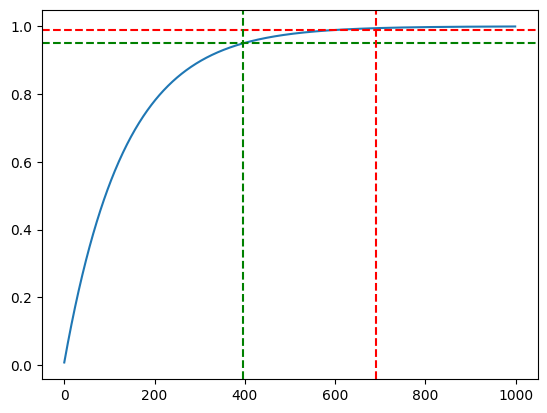

In [7]:
import numpy as np
import matplotlib.pyplot as plt

disc = 0.99
rslt = [disc**i for i in range(1000)]
plt.plot(np.cumsum(rslt)/np.sum(rslt))
plt.axhline(y=0.95, color='green', linestyle='dashed')
plt.axhline(y=0.99, color='red', linestyle='dashed')
x_95 = np.argmax(np.cumsum(rslt)/np.sum(rslt) > 0.95)
x_99 = np.argmax(np.cumsum(rslt)/np.sum(rslt) > 0.995)

plt.axvline(x=x_95, color='green', linestyle='dashed')
plt.axvline(x=x_99, color='red', linestyle='dashed')
plt.show()

plt.show()
